# Twitter US Airline Sentiment
<font color="red">Submitted By: Mayur Makadia</font>
<br/>
**Github: https://github.com/mayurmakadia1/UTAustin-PGP-AIML/tree/master/6-NLP/**

## **Context:**
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

- Dataset:
The project is from a dataset from Kaggle.
The dataset has the following columns:
- tweet_id
- airline_sentiment
- airline_sentiment_confidence
- negativereason
- negativereason_confidence
- airline
- airline_sentiment_gold
- name
- negativereason_gold
- retweet_count
- text
- tweet_coord
- tweet_created
- tweet_location
- user_timezone

### 1. Import the libraries, load dataset, print shape of data, data description

In [456]:
import re
import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import nltk                                         #Natural language processing tool-kit
import contractions
from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from nltk.tokenize import word_tokenize 
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

In [457]:
#load dataset
tweets = pd.read_csv("tweets.csv")

In [458]:
#shape of dataset
tweets.shape

(14640, 15)

In [459]:
#name of columns
tweets.columns.values

array(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], dtype=object)

In [460]:
#display full data
pd.set_option('display.max_colwidth', None)
#data preview
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [461]:
#description of dataset
tweets.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [462]:
#dataset column info
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

### 2. Understand data-columns

#### 2a. Drop all other columns except “text” and “airline_sentiment”

In [463]:
for i in tweets.columns.values:
    if ((i != "airline_sentiment") and (i != "text")):
        tweets = tweets.drop(i , axis=1)
        print(i)

tweet_id
airline_sentiment_confidence
negativereason
negativereason_confidence
airline
airline_sentiment_gold
name
negativereason_gold
retweet_count
tweet_coord
tweet_created
tweet_location
user_timezone


In [464]:
#drop the duplicate rows, only keep first occurrence
tweets.drop_duplicates(keep='first',inplace=True,ignore_index=True)

In [465]:
# Check for NULL values.
tweets.isnull().sum(axis=0)                                

airline_sentiment    0
text                 0
dtype: int64

#### 2b. Check the shape of data

In [466]:
tweets.shape

(14452, 2)

#### 2c. Print first 5 rows of data

In [467]:
tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


### 3. Text pre-processing: Data preparation

#### 3a. Html tag removal

In [468]:
#remove html tags
from bs4 import BeautifulSoup
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [469]:
tweets['textnew'] = tweets['text']
for i in range(0, tweets['text'].count()):
    tweets['textnew'][i] = strip_html_tags(tweets['text'][i])

In [470]:
tweets.head()

,airline_sentiment,text,textnew
0,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it,@VirginAmerica and it's a really big bad thing about it


In [471]:
#remove special characters
import re

stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))                      

def remove_stopwords(text):
    """Remove stop words from list of tokenized words"""
    return_text = ''
    if text not in stopwords:
        return_text = text
    return return_text

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    text = re.sub(r'[^\w\s]', '', text)
    return text

def to_lowercase(text):
    """Convert all characters to lowercase from list of tokenized words"""
    text = text.lower()           # Converting to lowercase
    return text

def stem_words(text):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    text = stemmer.stem(text)
    return text

def lemmatize_verbs(text):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    text = lemmatizer.lemmatize(text, pos='v')
    return text

####  Replace contractions
#### 3c. Remove the numbers
#### 3d. Remove special characters and punctuations
#### 3e .Conversion to lowercase

In [472]:
#3c, 3d, 3e
for i in range(0, tweets['textnew'].count()):
    newtxt = tweets['textnew'][i]
    newtxt = replace_contractions(newtxt)
    newtxt = remove_special_characters(newtxt,remove_digits=True)
    newtxt = remove_punctuation(newtxt)
    newtxt = to_lowercase(newtxt)
    tweets['textnew'][i] = newtxt

In [473]:
tweets.head()

,airline_sentiment,text,textnew
0,neutral,@VirginAmerica What @dhepburn said.,virginamerica what dhepburn said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,virginamerica plus you have added commercials to the experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,virginamerica i did not today must mean i need to take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces they have little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,virginamerica and it is a really big bad thing about it


#### 3b. Tokenization

In [474]:
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer=ToktokTokenizer()
for i in range(0, tweets['textnew'].count()):
    tweets['textnew'][i] = tokenizer.tokenize(tweets['textnew'][i])

In [475]:
tweets.head()

,airline_sentiment,text,textnew
0,neutral,@VirginAmerica What @dhepburn said.,"[virginamerica, what, dhepburn, said]"
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,"[virginamerica, plus, you, have, added, commercials, to, the, experience, tacky]"
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[virginamerica, i, did, not, today, must, mean, i, need, to, take, another, trip]"
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[virginamerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]"
4,negative,@VirginAmerica and it's a really big bad thing about it,"[virginamerica, and, it, is, a, really, big, bad, thing, about, it]"


#### 3f. Lemmatize or stemming and remove stopwords
#### 3g. Join the words in the list to convert back to text string in the dataframe

In [476]:
#lemmatize
arr = ""
for i in range(0, tweets['textnew'].count()):
    tweet = tweets['textnew'][i]
    arr = ""
    for j in tweet:
        #remove stopwords
        newtxt = remove_stopwords(j)
        if (newtxt != ''):
            newtxt = lemmatize_verbs(newtxt)
        #join the words to convert to a string
        arr = str(arr) + " " + str(newtxt)
    arr = arr.strip()
    tweets['textnew'][i] = arr

#### 3h. Print first 5 rows of data after pre-processing

In [477]:
tweets.head()

,airline_sentiment,text,textnew
0,neutral,@VirginAmerica What @dhepburn said.,virginamerica dhepburn say
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,virginamerica plus add commercials experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,virginamerica not today must mean need take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,virginamerica really big bad thing


In [478]:
#copy the pre-processed data to the text column
tweets['text'] = tweets['textnew']

In [479]:
#drop the textnew column which was created to apply all pre-processing of text data
tweets = tweets.drop('textnew', axis=1)

In [480]:
#review the pre-processed data
tweets.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica not today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


### 4. Vectorization

#### 4a. Use CountVectorizer

In [481]:
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
tweets_data_features = vectorizer.fit_transform(tweets['text'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
tweets_data_features = tweets_data_features.toarray()

Creating the bag of words...



In [482]:
print (tweets_data_features.shape)

(14452, 5000)


In [483]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print (vocab)

['aa', 'aaba', 'aadvantage', 'aafail', 'aal', 'aarp', 'aas', 'ab', 'abandon', 'abc', 'abcnetwork', 'abilities', 'ability', 'able', 'aboard', 'abq', 'abroad', 'absolute', 'absolutely', 'absurd', 'abt', 'abuse', 'abysmal', 'ac', 'accept', 'acceptable', 'access', 'accident', 'accidentally', 'accommodate', 'accommodations', 'accomplish', 'accord', 'accordingly', 'account', 'accountability', 'accrue', 'acct', 'accts', 'accurate', 'accuse', 'achieve', 'acknowledge', 'acknowledgement', 'acknowledgment', 'acquire', 'across', 'act', 'action', 'activate', 'active', 'activitiesprevention', 'actual', 'actually', 'ad', 'adam', 'add', 'addition', 'additional', 'address', 'addtl', 'adjacent', 'admiral', 'admirals', 'admit', 'adopt', 'adore', 'ads', 'adult', 'advance', 'advantage', 'advertise', 'advice', 'advise', 'advisories', 'advisory', 'aerojobmarket', 'affect', 'affiliate', 'afford', 'affordable', 'afraid', 'afterall', 'afternoon', 'age', 'agency', 'agent', 'agents', 'aggravate', 'aggressive', 'a

In [484]:
# Sum up the counts of each vocabulary word
dist = np.sum(tweets_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print (count, tag)

266 aa
2 aaba
10 aadvantage
2 aafail
2 aal
3 aarp
3 aas
2 ab
3 abandon
7 abc
2 abcnetwork
2 abilities
5 ability
118 able
4 aboard
9 abq
2 abroad
22 absolute
30 absolutely
13 absurd
7 abt
3 abuse
6 abysmal
10 ac
31 accept
23 acceptable
39 access
4 accident
4 accidentally
26 accommodate
8 accommodations
4 accomplish
11 accord
4 accordingly
80 account
6 accountability
2 accrue
10 acct
2 accts
10 accurate
2 accuse
3 achieve
4 acknowledge
2 acknowledgement
2 acknowledgment
2 acquire
16 across
18 act
13 action
2 activate
4 active
2 activitiesprevention
21 actual
86 actually
4 ad
2 adam
126 add
4 addition
17 additional
53 address
3 addtl
2 adjacent
4 admiral
13 admirals
6 admit
6 adopt
2 adore
5 ads
2 adult
14 advance
15 advantage
11 advertise
9 advice
20 advise
2 advisories
23 advisory
2 aerojobmarket
15 affect
3 affiliate
13 afford
3 affordable
2 afraid
2 afterall
30 afternoon
15 age
6 agency
255 agent
155 agents
3 aggravate
3 aggressive
2 agnt
126 ago
9 agree
3 agt
11 ah
17 ahead
4 ahhhh
8

5 communications
3 community
9 comp
41 companion
88 company
7 compare
9 compassion
2 compatible
3 comped
31 compensate
35 compensation
3 compete
3 competent
4 competition
3 competitor
2 competitors
20 complain
45 complaint
26 complaints
35 complete
37 completely
2 compliant
3 complicate
7 compliment
9 complimentary
2 compound
2 comps
45 computer
13 computers
3 con
2 concentrate
3 concept
44 concern
4 concert
6 concourse
2 condescend
20 condition
2 condomrito
2 conection
25 conf
9 conference
3 confidence
4 confident
73 confirm
67 confirmation
2 confirmations
6 conflict
15 confuse
5 confusion
17 congrats
4 congratulations
126 connect
148 connection
34 connections
4 connector
4 consecutive
32 consider
4 consideration
2 consistency
9 consistent
8 consistently
2 consolation
6 constant
5 constantly
2 construction
3 consumers
8 cont
120 contact
3 contain
2 contd
7 content
12 contest
2 context
4 continental
3 contingency
3 continually
38 continue
3 continuous
6 contract
30 control
2 controller

2 letdown
4 letsgo
30 letter
17 level
2 lexington
2 lf
51 lga
2 lgb
4 lh
10 lhr
2 liable
2 liars
6 license
48 lie
3 lieflat
54 life
7 lifetime
2 lift
23 light
428 like
3 likelihood
17 likely
2 lil
2 lima
18 limit
3 lindsey
206 line
73 link
4 lisa
46 list
32 listen
29 literally
67 little
2 littlebirds
56 live
8 livery
3 livid
6 lmao
4 lmfao
2 lo
55 load
2 loan
2 loaner
3 loc
9 local
3 locals
23 locate
7 location
6 locations
12 locator
6 lock
5 lodge
19 log
14 logan
2 loganairports
3 logic
5 login
4 logistics
3 logo
55 lol
14 london
3 lone
182 long
60 longer
286 look
2 lookin
2 looong
2 loooooong
3 loop
9 loose
3 lord
2 los
322 lose
2 losers
7 loss
4 lostluggage
91 lot
2 loud
7 louis
5 louisville
35 lounge
8 lousy
306 love
10 love_dragonss
4 lovejetblue
19 lovely
3 lovesongfriday
14 low
13 lower
4 lowest
52 loyal
12 loyalty
2 lr
2 lucia
35 luck
8 luckily
10 lucky
8 lufthansa
259 luggage
2 luggages
5 lunch
2 lusaka
3 luvswa
2 luxurious
3 lynn
2 maatkare
2 mac
8 machine
16 mad
2 madam
4 ma

2 russia
2 ruth
2 sa_craig
4 sabre
4 sacramento
36 sad
3 sadden
10 sadly
4 safari
23 safe
16 safely
38 safety
3 safetyfirst
3 saga
10 sale
5 sales
2 sally
9 salt
2 samartzis
2 sammi_jons
2 sample
76 san
2 sand
2 sandiego
4 sandwich
3 sanfrancisco
2 sanitize
2 sanitizer
2 sanity
2 sanm
4 santa
7 sarcasm
2 sass
2 satisfaction
2 satisfactory
3 satisfy
26 saturday
3 sauce
2 sav
6 savannah
37 save
3 saver
2 savethediagonals
28 saw
500 say
4 sayin
4 sb
4 sc
6 scale
6 scam
8 scan
5 scar
2 scatter
8 scavenger
2 scenario
3 scene
2 sch
4 sched
98 schedule
3 scheme
15 school
2 science
2 sciencebehindtheexperience
2 scotch
4 scott
2 scratch
4 scream
19 screen
2 screenshot
47 screw
4 sdf
14 sea
2 seam
3 sean
12 search
2 season
509 seat
3 seatac
2 seatback
2 seatbelt
20 seattle
5 sec
58 second
2 secret
4 section
9 secure
22 security
2 sedholm
313 see
9 seek
101 seem
3 seg
8 segment
31 select
4 selection
2 selections
4 self
8 selfie
2 selfies
2 selfservice
40 sell
315 send
2 senior
33 sense
2 sensele

negative    9087
neutral     3067
positive    2298
Name: airline_sentiment, dtype: int64


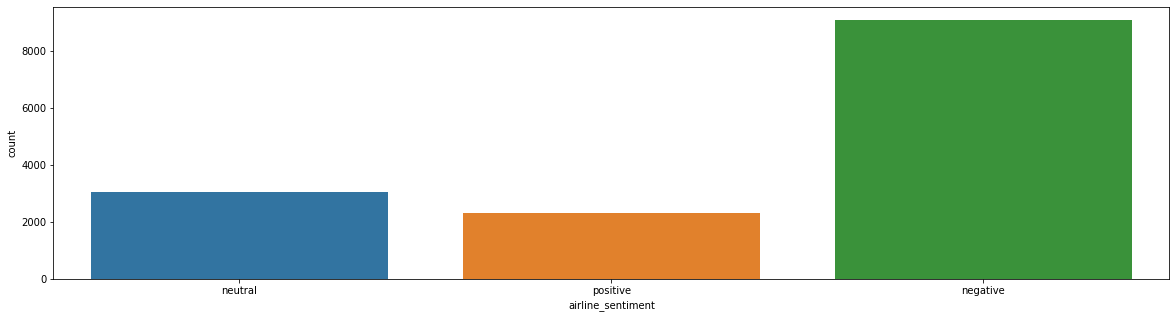

In [485]:
y = tweets['airline_sentiment']
print(y.value_counts())
plt.figure(figsize=(20,5)) 
g = sns.countplot(y)

In [486]:
#update the text values of airline_sentiment to numeric values
#1 = Negative, 2 = Neutral, 3 = Positive
tweets.loc[tweets['airline_sentiment'] == 'negative','airline_sentiment'] = 1
tweets.loc[tweets['airline_sentiment'] == 'neutral','airline_sentiment'] = 2
tweets.loc[tweets['airline_sentiment'] == 'positive','airline_sentiment'] = 3

In [487]:
x = tweets_data_features
y = tweets['airline_sentiment'] 
y = y.astype('int')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)  # 1 is just any random seed number

In [488]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10116, 5000)
(10116,)
(4336, 5000)
(4336,)


In [489]:
# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(verbose=2,n_jobs=4,n_estimators=100) 
# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
print ("Training the random forest...")
#forest = forest.fit(tweets_data_features, tweets["airline_sentiment"] )
forest = forest.fit(x_train, y_train )
# random forest performance through cross vaidation 
print (forest)
print (np.mean(cross_val_score(forest,x_train,y_train,cv=10)))

Training the random forest...
building tree 1 of 100building tree 2 of 100


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.



building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.9s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   14.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=None, verbose=2,
                       warm_start=False)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   21.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   17.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 100

0.7625545872868799


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [490]:
#test score
countvectorizerscore = forest.score(x_test,y_test)
print(countvectorizerscore)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s


0.7585332103321033


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [491]:
# Make class predictions for the test set
y_test_predict= forest.predict(x_test)
print(y_test_predict)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[1 1 1 ... 2 1 2]


In [492]:
print(classification_report(y_test,y_test_predict))

              precision    recall  f1-score   support

           1       0.80      0.91      0.85      2724
           2       0.60      0.45      0.51       941
           3       0.71      0.59      0.64       671

    accuracy                           0.76      4336
   macro avg       0.71      0.65      0.67      4336
weighted avg       0.74      0.76      0.75      4336



[[2476  180   68]
 [ 431  419   91]
 [ 178   99  394]]


<AxesSubplot:>

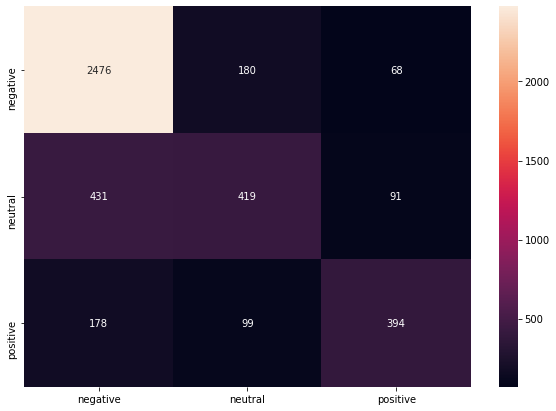

In [493]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
conf_mat = confusion_matrix(y_test, y_test_predict)

print(conf_mat)
#1 = Negative, 2 = Neutral, 3 = Positive
df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative','neutral','positive']],
                  columns = [i for i in ['negative','neutral','positive']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [494]:
# Initialize the "TfidfVectorizer" object
tfidf_vectorizer = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000,
                             min_df=5, 
                             max_df=0.7,
                             ngram_range=(1,2)) 

tfidf_vectorizer_data_features = tfidf_vectorizer.fit_transform(tweets['text'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
tfidf_vectorizer_data_features = tfidf_vectorizer_data_features.toarray()

In [495]:
x = tfidf_vectorizer_data_features
y = tweets['airline_sentiment'] 
y = y.astype('int')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)  # 1 is just any random seed number

In [496]:
forest = RandomForestClassifier(verbose=2,n_jobs=4,n_estimators=100) 
print ("Training the random forest...")
forest = forest.fit(x_train, y_train )
# random forest performance through cross vaidation 
print (forest)
print (np.mean(cross_val_score(forest,x_train,y_train,cv=10)))

Training the random forest...
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100building tree 22 of 100

building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.3s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100building tree 55 of 100

building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   17.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=None, verbose=2,
                       warm_start=False)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   18.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   16.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 100

0.7546465167739842


In [497]:
#test score
tfidscore = forest.score(x_test,y_test)
print(tfidscore)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s


0.7580719557195572


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [498]:
# Make class predictions for the test set
y_test_predict= forest.predict(x_test)
print(y_test_predict)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[1 1 1 ... 2 1 1]


In [499]:
#1 = Negative, 2 = Neutral, 3 = Positive
print(classification_report(y_test,y_test_predict))

              precision    recall  f1-score   support

           1       0.79      0.93      0.85      2724
           2       0.61      0.40      0.49       941
           3       0.74      0.54      0.62       671

    accuracy                           0.76      4336
   macro avg       0.71      0.63      0.66      4336
weighted avg       0.74      0.76      0.74      4336



[[2544  130   50]
 [ 484  381   76]
 [ 199  110  362]]


<AxesSubplot:>

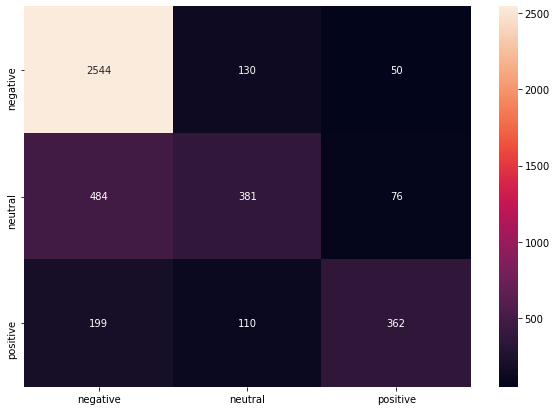

In [500]:
conf_mat = confusion_matrix(y_test, y_test_predict)

print(conf_mat)
#1 = Negative, 2 = Neutral, 3 = Positive
df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative','neutral','positive']],
                  columns = [i for i in ['negative','neutral','positive']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

### Model Summary:

- Tweet dataset has negative, neutral and positive sentiments about US Airline.
- The goal was to build a model for text-classification of review sentiments.
- Pre-processed the data using variuos techniques and libraries to cleanup the reviews data. Data cleanup included html tag removal, remove contractions, tokenization, removing the numbers, removing special characters and punctuations, conversion to lowercase, remove stopwords, lemmatize.
- The pre-precessed data is converted to numbers, so that it can be used in the model. Count vectorizer and TdIdf vectorizer were both used to see how the model performs with these techniques.
- After building the classification model in random forest, test data results were predicted using count vectorizer and TdIdf vectorizer.
- After that we saw that using the above techniques, count vectorizer results had testing accuracy of 75.85% and TdIdf vectorizer results had testing accuracy of 75.81%.
- Classification reports were created to show the precision, recall and f1-score.
- The accuracy of the model can still be increased by applying GridSearch techniques to tune the model parameters and also by increasing the input data features.
- Also one other way to increase accuracy would be to use different variations of pre-processing techniques.
- Since the data is imbalanced, over sampling for neutral and positive reviews should also help improving accuracy of the model